In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from qiskit import Aer, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.opflow import Z, I, StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient, PauliExpectation
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import  ZZFeatureMap, MCMT, RYGate
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library.standard_gates import HGate

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN, OpflowQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 42



from auxData import Load_DataFull, plot_sampled_data_sepal, plot_predicted, plot_sampled_data_petal, Load_DataMultiClass

**No qiskit podemos representar algumas redes neurais quânticas**

Temos as funções *OPflowQNN(), TwoLayerQNN(), CircuitQNN()*.

**OPflowQNN()** vai receber o circuito como entrada, e aceita como parâmetros os pesos que seriam para input e para o ansatz. Argumentos que utilizaremos:

- _Operator (OperatorBase)_ – O operador parametrizado que representa o circuito. Vamos ter que aplicar StateFN antes (Demonstração abaixo)

- _input_params_ (Optional[List[Parameter]]) –Lista de parâmetros do Feature Map/input da rede.

- _weight_params_ (Optional[List[Parameter]]) – Lista de parâmetros do Ansatz (os pesos do treinamento) da rede.

- _exp_val_ (Optional[ExpectationBase]) – Um Conversor do valor esperado. Para classificação usarei o PauliExpectation(). Default: identidade

- _gradient_ (Optional[Gradient]) – Um conversor para converter a expressão do operador para um gradiente, para realizar o backward pass.

- _quantum_instance_ (Union[Backend, QuantumInstance, None]) – A quantum instance usada para avaliar a rede.





**TwoLayerQNN()** é o caso especial em que você divide o circuito em feature map e ansatz, que seriam as duas camadas.

- num_qubits (Optional[int]) – Número de qubits no circuito

- feature_map (Optional[QuantumCircuit]) – O feature map

- ansatz (Optional[QuantumCircuit]) – O Ansatz

- observable (Optional[OperatorBase]) – O observável a ser medido. Default: Z^{otimes num_qubits}.

- exp_val (Optional[ExpectationBase]) – Um Conversor do valor esperado. Default: identidade

- quantum_instance (Union[Backend, QuantumInstance, None]) – A quantum instance usada.



**CircuitQNN()** Podemos personalizar o interpretador.

- circuit (QuantumCircuit) – O circuito parametrizado.

- input_params (Optional[List[Parameter]]) – Parâmetros do Feature_map/input

- weight_params (Optional[List[Parameter]]) – Parâmetros do ansatz, pesos do treinamento.

- interpret (Optional[Callable[[int], Union[int, Tuple[int, …]]]]) – Relacionado com a forma de como "interpretar" o output

- output_shape (Union[int, Tuple[int, …], None]) – O formato do output, definir caso um interpret seja fornecido. Default (interpret=None): 2^num_qubits (num_samples,1) 

- gradient (Optional[Gradient]) – Um conversor do gradiente usado para o gradientes de probablidade.

- quantum_instance (Union[Backend, QuantumInstance, None]) – A quantum instance usada.

# Classificação binária

O Feature/Input map

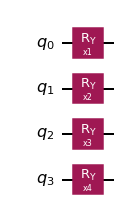

In [2]:
#Mostrar o circuito encoder
dim = 4
param_x1 = Parameter("x1")
param_x2 = Parameter("x2")
param_x3 = Parameter("x3")
param_x4 = Parameter("x4")

feature_map = QuantumCircuit(dim)
feature_map.ry(param_x1, 0)
feature_map.ry(param_x2, 1)
feature_map.ry(param_x3, 2)
feature_map.ry(param_x4, 3)
#psi = cos(x1)state0 + sen(x1)state1

feature_map.draw('mpl', style='iqx')

O nosso ansatz

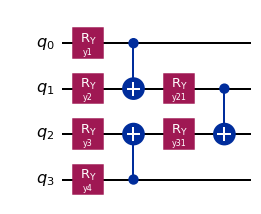

In [3]:
ansatz = QuantumCircuit(dim)
param_y1 = Parameter("y1")
param_y2 = Parameter("y2")
param_y3 = Parameter("y3")
param_y4 = Parameter("y4")
ansatz.ry(param_y1, 0)
ansatz.ry(param_y2, 1)
ansatz.ry(param_y3, 2)
ansatz.ry(param_y4, 3)
ansatz.cx(0,1)
ansatz.cx(3,2)
param_y21 = Parameter("y21")
param_y31 = Parameter("y31")
ansatz.ry(param_y21, 1)
ansatz.ry(param_y31, 2)
ansatz.cx(1,2)
#param_y311 = Parameter("y311")
#ansatz.ry(param_y311, 2)
ansatz.draw('mpl', style='iqx')

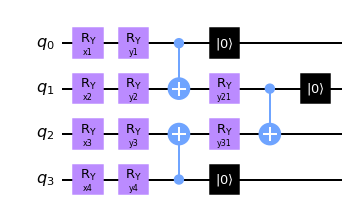

In [4]:
qc = QuantumCircuit(dim)
qc.append(feature_map, range(dim))
qc.append(ansatz, range(dim))
qc.reset(0)
qc.reset(1)
qc.reset(3)
qc.decompose().draw(output="mpl")

### O dataset que queremos classificar

Dataset Iris:

- 3 Classes: Iris-setosa, Iris-versicolor, Iris-virginica

- Dataset balanceado, com 50 instâncias para cada classe

- 4 atributos: Sepal length, Sepal width, Petal length, Petal width

In [5]:
dataset = pd.read_csv("data/iris.data")
dataset1 = dataset[dataset["class"] == "Iris-setosa"]
dataset2 = dataset[dataset["class"] == "Iris-versicolor"]
dataset3 = dataset[dataset["class"] == "Iris-virginica"]
dataset1_train, dataset1_test = train_test_split(dataset1, test_size=0.33, random_state=25)
dataset2_train, dataset2_test = train_test_split(dataset2, test_size=0.33, random_state=25)
dataset3_train, dataset3_test = train_test_split(dataset3, test_size=0.33, random_state=25)
dataset_list_train = [dataset1_train, dataset2_train, dataset3_train]
dataset_list_test = [dataset1_test, dataset2_test, dataset3_test]
training_features, training_labels, test_features, test_labels = Load_DataFull(1,2, dataset_list_train,dataset_list_test )

class
Iris-setosa        33
Iris-versicolor    33
dtype: int64
class
Iris-setosa        17
Iris-versicolor    17
dtype: int64


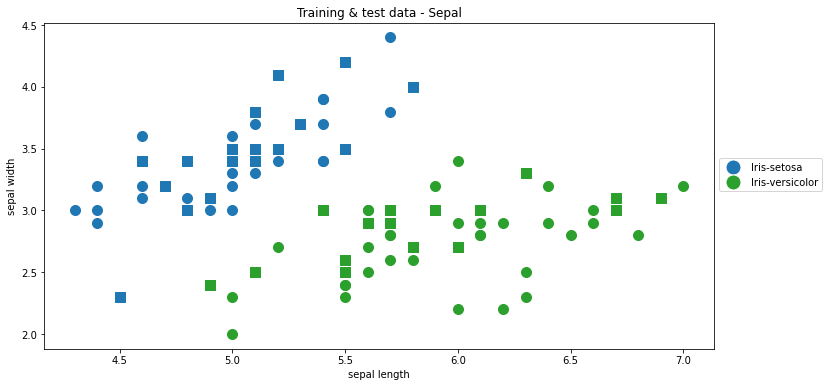

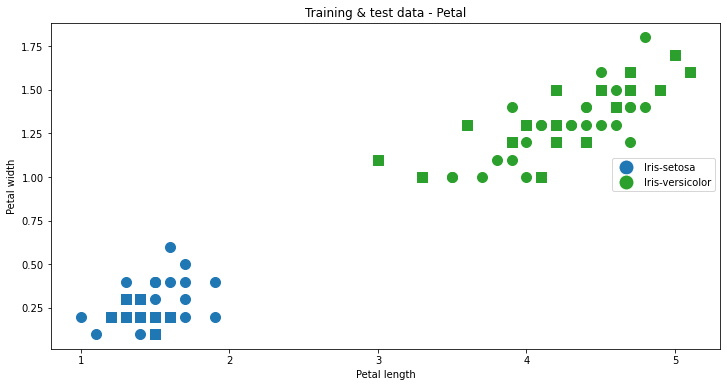

In [6]:
plot_sampled_data_sepal(training_features, training_labels, test_features, test_labels)
plot_sampled_data_petal(training_features, training_labels, test_features, test_labels)

Definimos umas função de callback para termos um gráfico do Loss

In [8]:
#Função de Callback que produzirá os gráficos
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Definimos o Quantum Instance, o Hamiltoniano e o qnn_expectation

In [9]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)
hamiltonian = I ^ Z^ I ^ I
qnn_expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(qc)
qnn = OpflowQNN(qnn_expectation, 
                input_params=list(feature_map.parameters), 
                weight_params=list(ansatz.parameters),
                exp_val=PauliExpectation(),
                gradient=Gradient(),  
                quantum_instance=quantum_instance)



In [10]:
opflow_classifier = NeuralNetworkClassifier(qnn, optimizer=COBYLA(), callback=callback_graph)


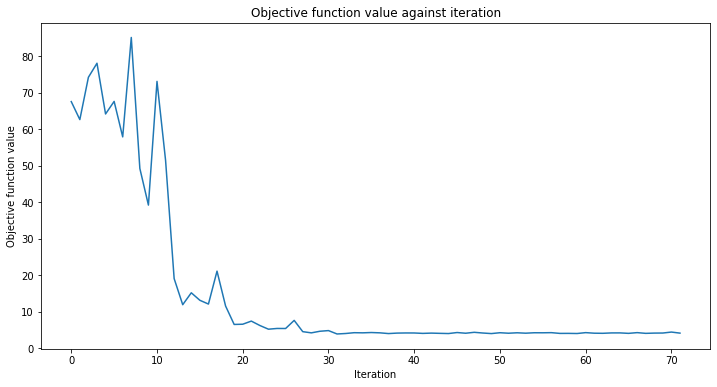

1.0

In [11]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(training_features, training_labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(training_features, training_labels)

Wrong predicted: 0


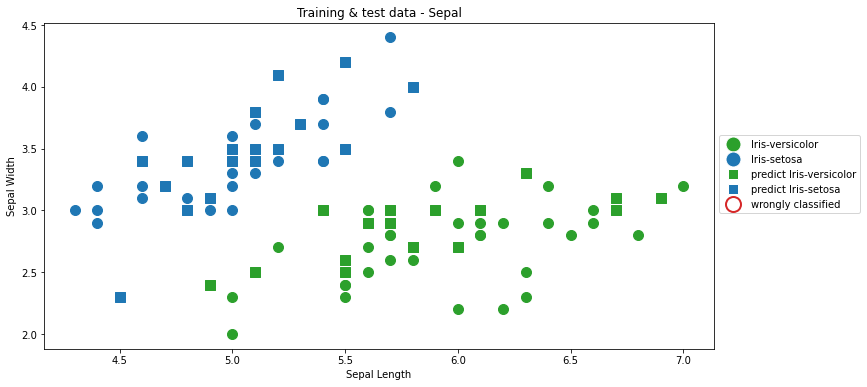

In [11]:
predicted = opflow_classifier.predict(test_features)

def plot_predicted(a,b, training_features, training_labels, test_features, test_labels):
    from matplotlib.lines import Line2D
    wrong_predicted = 0
    plt.figure(figsize=(12, 6))
    label_train = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    label_test = ['predict Iris-setosa', 'predict Iris-versicolor', 'predict Iris-virginica']
    for feature, label in zip(training_features, training_labels):
        marker = 'o' 
        color = 'tab:green' if label == -1 else 'tab:blue'
        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    for feature, label, pred in zip(test_features, test_labels, predicted):
        marker = 's' 
        color = 'tab:green' if pred == -1 else 'tab:blue'
        if label != pred:  # mark wrongly classified
            wrong_predicted+=1
            plt.scatter(feature[0], feature[1], marker='o', s=500, linewidths=2.5,
                        facecolor='none', edgecolor='tab:red')

        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    legend_elements = [
        Line2D([0], [0], marker='o', c='w', mfc='tab:green', label=label_train[b-1], ms=15),
        Line2D([0], [0], marker='o', c='w', mfc='tab:blue', label=label_train[a-1], ms=15),
        Line2D([0], [0], marker='s', c='w', mfc='tab:green', label=label_test[b-1], ms=10),
        Line2D([0], [0], marker='s', c='w', mfc='tab:blue', label=label_test[a-1], ms=10),
        Line2D([0], [0], marker='o', c='w', mfc='none', mec='tab:red', label='wrongly classified', mew=2, ms=15)
    ]

    plt.legend(loc= "lower left", handles=legend_elements, bbox_to_anchor=(1.0, 0.4))
    plt.title('Training & test data - Sepal')
    plt.xlabel('Sepal Length')
    plt.ylabel('Sepal Width')
    print("Wrong predicted:", wrong_predicted)
    
plot_predicted(1,2,training_features, training_labels, test_features, test_labels)

In [28]:
#Para fazer o fit do VQC temos que usar o one-hot
#0 - 100
#1 - 010
#2 - 001
'''
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(),
    quantum_instance=quantum_instance,
    callback=callback_graph,
)
'''

'\nvqc = VQC(\n    feature_map=feature_map,\n    ansatz=ansatz,\n    loss="cross_entropy",\n    optimizer=COBYLA(),\n    quantum_instance=quantum_instance,\n    callback=callback_graph,\n)\n'

# Classificação multi-classe

In [12]:
dataset_train = pd.concat([dataset1_train, dataset2_train, dataset3_train])
dataset_test = pd.concat([dataset1_test, dataset2_test, dataset3_test])
training_features, training_labels, test_features, test_labels = Load_DataMultiClass(dataset_train, dataset_test)

class
Iris-setosa        33
Iris-versicolor    33
Iris-virginica     33
dtype: int64
class
Iris-setosa        17
Iris-versicolor    17
Iris-virginica     17
dtype: int64


In [13]:

def parity(x):
    return "{:b}".format(x).count("1") % 3


output_shape = 3  # Número de classes, tem que estar coerente com o parity()


# construct QNN
circuit_qnn = CircuitQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    quantum_instance=quantum_instance,
)


In [14]:
multiclass_classifier = NeuralNetworkClassifier(circuit_qnn, optimizer=SLSQP(), callback=callback_graph)

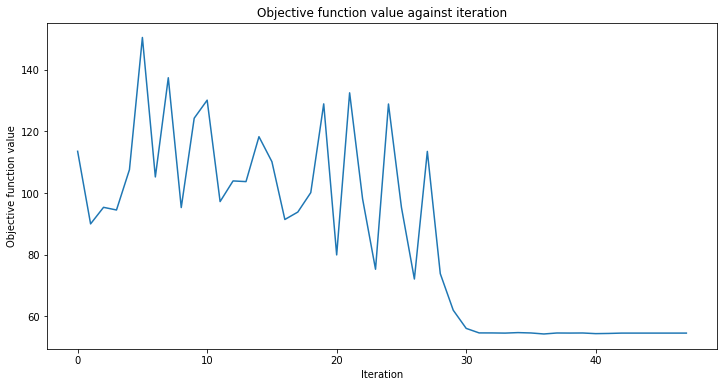

0.6565656565656566

In [15]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Fit
multiclass_classifier.fit(training_features, training_labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# Média da Acurácia do Classificador
multiclass_classifier.score(training_features, training_labels)

Wrong predicted: 19


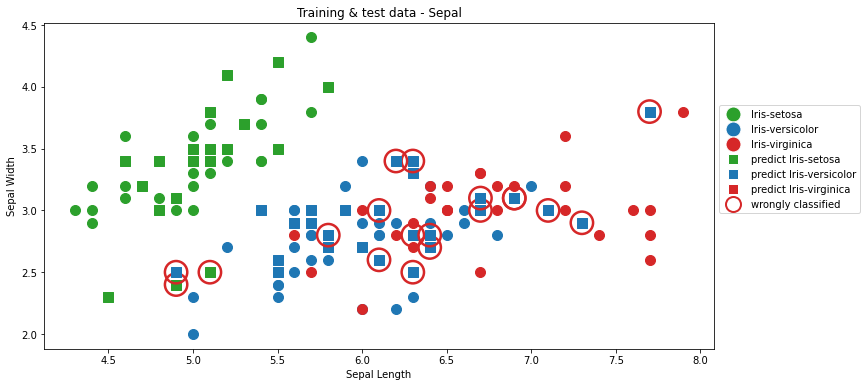

In [16]:
predicted = multiclass_classifier.predict(test_features)
def plot_predicted_multiclass(training_features, training_labels, test_features, test_labels):
    from matplotlib.lines import Line2D
    wrong_predicted = 0
    plt.figure(figsize=(12, 6))
    label_train = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    label_test = ['predict Iris-setosa', 'predict Iris-versicolor', 'predict Iris-virginica']
    for feature, label in zip(training_features, training_labels):
        marker = 'o' 
        color = 'tab:green' if label == 0 else 'tab:blue' if label ==1 else 'tab:red'
        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    for feature, label, pred in zip(test_features, test_labels, predicted):
        marker = 's' 
        color = 'tab:green' if pred == 0 else 'tab:blue' if pred ==1 else 'tab:red'
        if label != pred:  # mark wrongly classified
            wrong_predicted+=1
            plt.scatter(feature[0], feature[1], marker='o', s=500, linewidths=2.5,
                        facecolor='none', edgecolor='tab:red')

        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    legend_elements = [
        Line2D([0], [0], marker='o', c='w', mfc='tab:green', label=label_train[0], ms=15),
        Line2D([0], [0], marker='o', c='w', mfc='tab:blue', label=label_train[1], ms=15),
        Line2D([0], [0], marker='o', c='w', mfc='tab:red', label=label_train[2], ms=15),
        Line2D([0], [0], marker='s', c='w', mfc='tab:green', label=label_test[0], ms=10),
        Line2D([0], [0], marker='s', c='w', mfc='tab:blue', label=label_test[1], ms=10),
        Line2D([0], [0], marker='s', c='w', mfc='tab:red', label=label_test[2], ms=10),
        Line2D([0], [0], marker='o', c='w', mfc='none', mec='tab:red', label='wrongly classified', mew=2, ms=15)
    ]

    plt.legend(loc= "lower left", handles=legend_elements, bbox_to_anchor=(1.0, 0.4))
    plt.title('Training & test data - Sepal')
    plt.xlabel('Sepal Length')
    plt.ylabel('Sepal Width')
    print("Wrong predicted:", wrong_predicted)
    
plot_predicted_multiclass(training_features, training_labels, test_features, test_labels)

Wrong predicted: 19


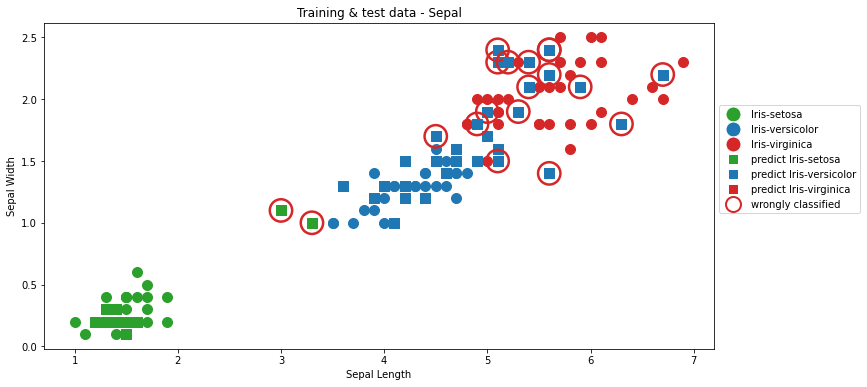

In [17]:
def plot_predicted_multiclass_petals(training_features, training_labels, test_features, test_labels):
    from matplotlib.lines import Line2D
    wrong_predicted = 0
    plt.figure(figsize=(12, 6))
    label_train = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    label_test = ['predict Iris-setosa', 'predict Iris-versicolor', 'predict Iris-virginica']
    for feature, label in zip(training_features, training_labels):
        marker = 'o' 
        color = 'tab:green' if label == 0 else 'tab:blue' if label ==1 else 'tab:red'
        plt.scatter(feature[2], feature[3], marker=marker, s=100, color=color)
    
    for feature, label, pred in zip(test_features, test_labels, predicted):
        marker = 's' 
        color = 'tab:green' if pred == 0 else 'tab:blue' if pred ==1 else 'tab:red'
        if label != pred:  # mark wrongly classified
            wrong_predicted+=1
            plt.scatter(feature[2], feature[3], marker='o', s=500, linewidths=2.5,
                        facecolor='none', edgecolor='tab:red')

        plt.scatter(feature[2], feature[3], marker=marker, s=100, color=color)
    
    legend_elements = [
        Line2D([0], [0], marker='o', c='w', mfc='tab:green', label=label_train[0], ms=15),
        Line2D([0], [0], marker='o', c='w', mfc='tab:blue', label=label_train[1], ms=15),
        Line2D([0], [0], marker='o', c='w', mfc='tab:red', label=label_train[2], ms=15),
        Line2D([0], [0], marker='s', c='w', mfc='tab:green', label=label_test[0], ms=10),
        Line2D([0], [0], marker='s', c='w', mfc='tab:blue', label=label_test[1], ms=10),
        Line2D([0], [0], marker='s', c='w', mfc='tab:red', label=label_test[2], ms=10),
        Line2D([0], [0], marker='o', c='w', mfc='none', mec='tab:red', label='wrongly classified', mew=2, ms=15)
    ]

    plt.legend(loc= "lower left", handles=legend_elements, bbox_to_anchor=(1.0, 0.4))
    plt.title('Training & test data - Sepal')
    plt.xlabel('Sepal Length')
    plt.ylabel('Sepal Width')
    print("Wrong predicted:", wrong_predicted)
    
plot_predicted_multiclass_petals(training_features, training_labels, test_features, test_labels)

# Regressão

Gerando uma função seno ruidosa

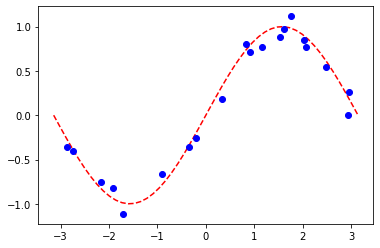

In [18]:

num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

Montando nosso circuito simples

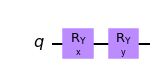

In [19]:
param_x = Parameter("x")
feature_map = QuantumCircuit(1)
feature_map.ry(param_x, 0)


param_y = Parameter("y")
ansatz = QuantumCircuit(1 )
ansatz.ry(param_y, 0) 

qc = QuantumCircuit(1)
qc.append(feature_map, [0])
qc.append(ansatz, [0])
qc.decompose().draw(output="mpl")

Usando o TwoLayerQNN para fazer o NeuralNetworkRegressor

In [20]:

regression_opflow_qnn = TwoLayerQNN(1, feature_map, ansatz, quantum_instance=quantum_instance)
regressor = NeuralNetworkRegressor(
    neural_network=regression_opflow_qnn, loss="l2", optimizer=SLSQP(), callback=callback_graph
)

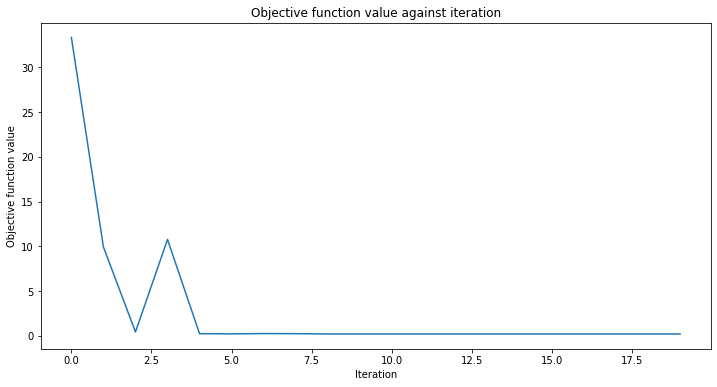

0.9724259551776512

In [21]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Fit
regressor.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# Para regressão o score é o R^2
regressor.score(X, y)


Plotando em verde nossa função aproximada pela rede neural

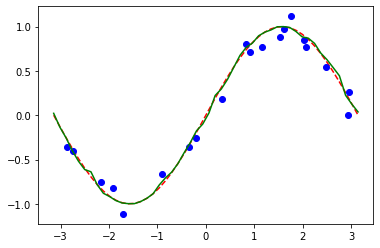

In [22]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

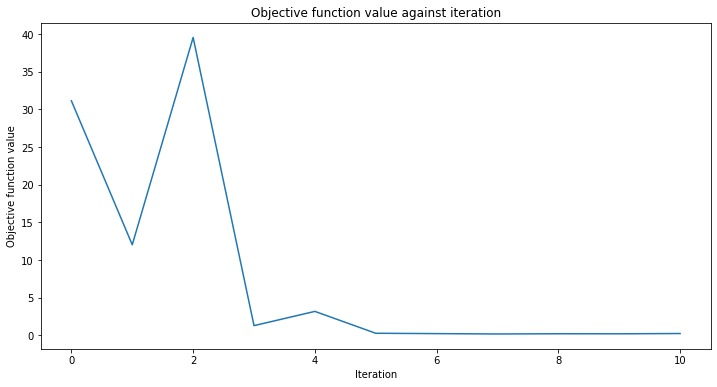

0.9747502079860045

In [24]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(),
    quantum_instance=quantum_instance,
    callback=callback_graph,
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(X, y)

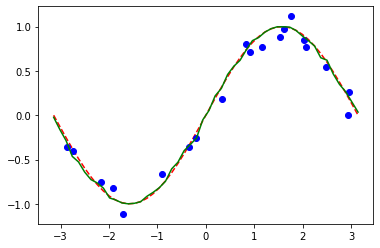

In [25]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = vqr.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()